# Tensorflow Timeseries Tutorial 

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import modin.pandas as pd
import seaborn as sns
import tensorflow as tf

2024-07-11 15:06:03.777831: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 15:06:03.864747: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 15:06:04.194715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 15:06:05.169610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#set a defult figure size for matplotlib
mpl.rcParams['figure.figsize'] = (8, 6)

In [3]:
# download the data from tesnsorflows data sets and saves it locally to ~/.keras/datasets
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
#gives the pathe to the extraded csv
csv_path, _ = os.path.splitext(zip_path)
     

In [4]:
#as we are using hourly predictions we start by sub-sampling the data from 10-minute intervals to one-hour intervals
df = pd.read_csv(csv_path)

# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Inspection and Cleaning 

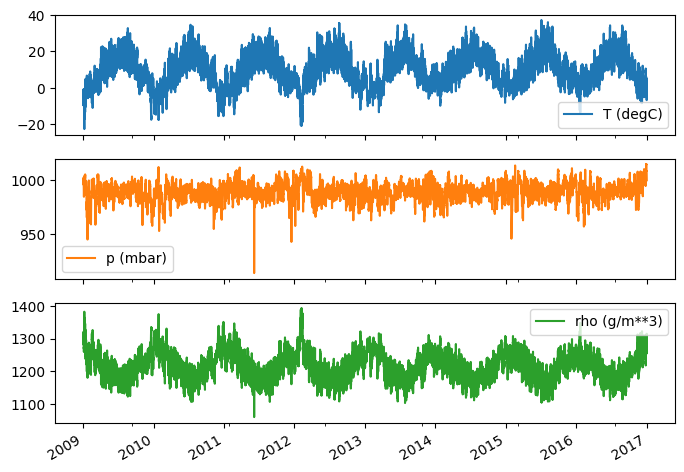

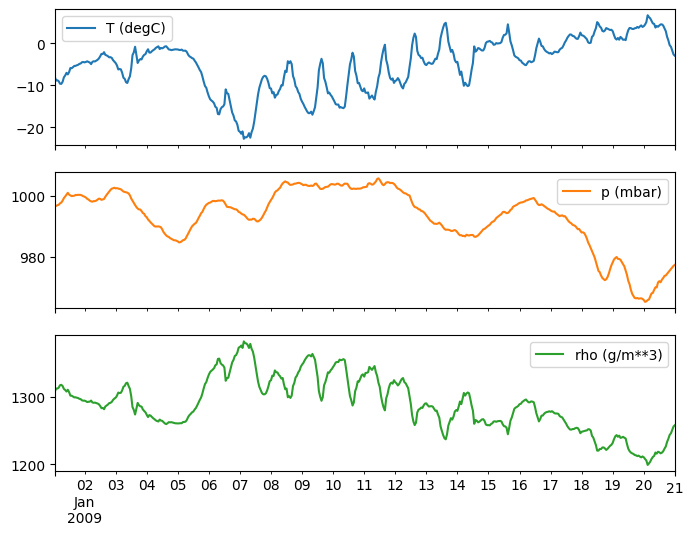

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
#One thing that should stand out is the min value of the wind velocity (wv (m/s)) and the maximum value (max. wv (m/s)) columns. 
#This -9999 is likely erroneous. so will replace it with 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# Feature Egnineering

Wind
The last column of the data, wd (deg)—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

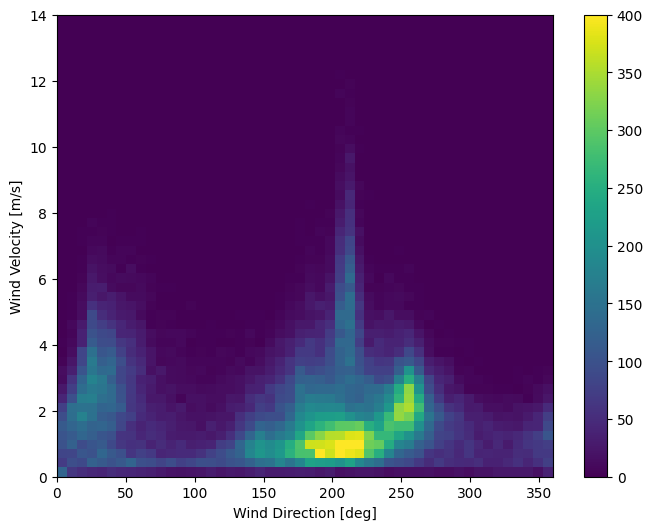

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.600000,984.200000,989.570000,994.720000,1015.290000
T (degC),70091.0,9.450482,8.423384,-22.760000,3.350000,9.410000,15.480000,37.280000
Tpot (K),70091.0,283.493086,8.504424,250.850000,277.440000,283.460000,289.530000,311.210000
Tdew (degC),70091.0,4.956471,6.730081,-24.800000,0.240000,5.210000,10.080000,23.060000
rh (%),70091.0,76.009788,16.474920,13.880000,65.210000,79.300000,89.400000,100.000000
VPmax (mbar),70091.0,13.576576,7.739883,0.970000,7.770000,11.820000,17.610000,63.770000
VPact (mbar),70091.0,9.533968,4.183658,0.810000,6.220000,8.860000,12.360000,28.250000
VPdef (mbar),70091.0,4.042536,4.898549,0.000000,0.870000,2.190000,5.300000,46.010000
sh (g/kg),70091.0,6.022560,2.655812,0.510000,3.920000,5.590000,7.800000,18.070000
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.810000,6.290000,8.960000,12.490000,28.740000


(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

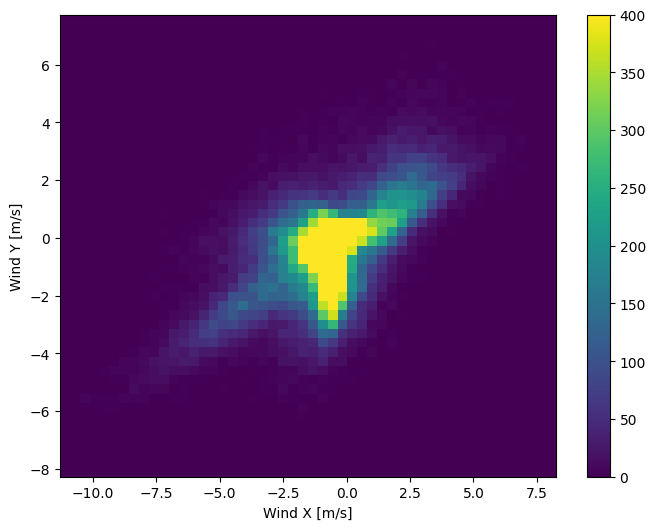

In [12]:

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [13]:
#Similarly, the Date Time column is very useful, but not in this string form. Start by converting it to seconds:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [14]:

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

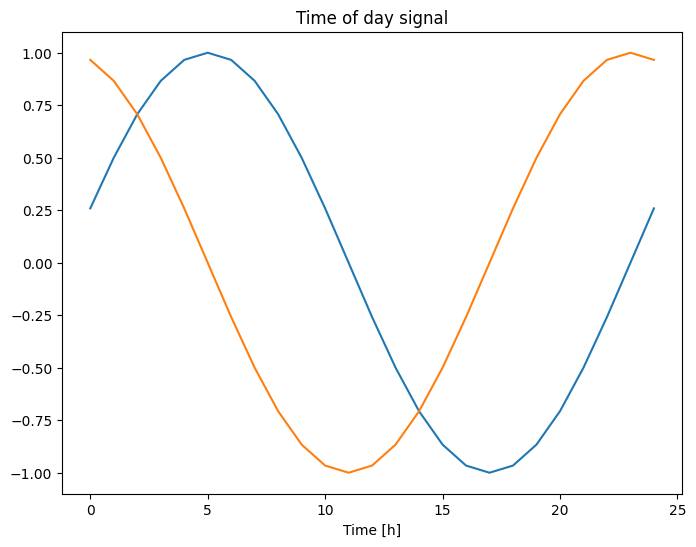

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
     

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you don't have that information, you can determine which frequencies are important by extracting features with Fast Fourier Transform. To check the assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:

Adding cyclical features like `Day sin`, `Day cos`, `Year sin`, and `Year cos` helps machine learning models better capture and understand the periodic nature of time-based data. Here’s why and how it helps:

### Benefits of Cyclical Features

1. **Handling Cyclical Nature**:
   - Time-related data, such as hours in a day or months in a year, is cyclical. For example, after 23:00 comes 00:00, not 24:00. Similarly, December is followed by January.
   - Using plain numerical encoding for such features can mislead the model into thinking there is a linear relationship between values, whereas they are actually cyclical.

2. **Smooth Transitions**:
   - The sine and cosine transformations ensure smooth transitions between the end and start of cycles. For example, the transition from 23:00 to 00:00 is smooth because both 23:00 and 00:00 will have similar sine and cosine values.
   - This helps models to understand that these points are close to each other in time, unlike using just hour values directly, where 23 and 0 are numerically far apart.

3. **Capturing Seasonal Patterns**:
   - Many real-world phenomena are affected by daily or yearly cycles (e.g., electricity usage, temperature variations, traffic patterns).
   - By capturing these periodic patterns, the model can make more accurate predictions based on the time of day or year.

### Example Application in a DataFrame

Here's a full example, including how to add these features to a DataFrame and use them in a model:


2024-07-11 15:06:31.450325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:06:31.451605: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


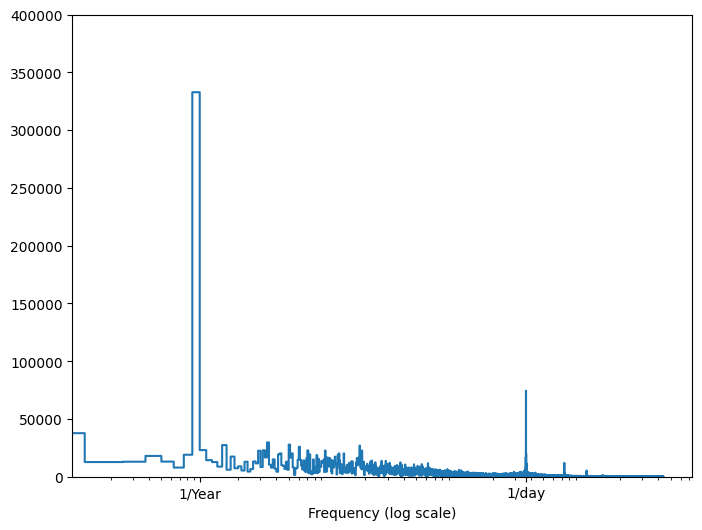

In [16]:

fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Split the data
You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the -9999 wind velocity value.

Order of rows could be different from pandas.


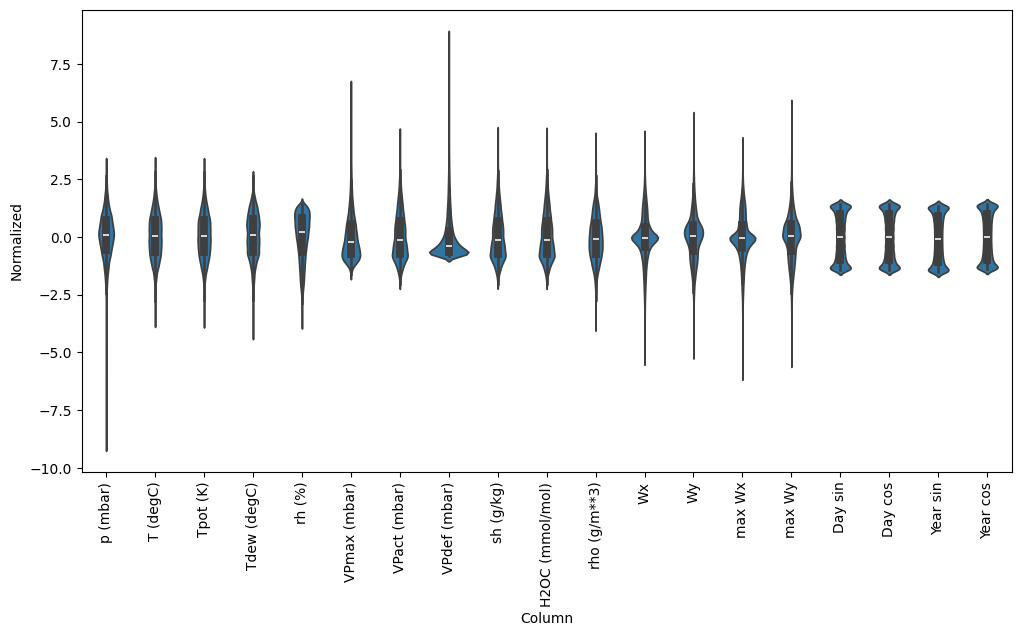

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing
The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- Single-output, and multi-output predictions.
- Single-time-step and multi-time-step predictions.
- This section focuses on implementing the data windowing so that it can be reused for all of those models.

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

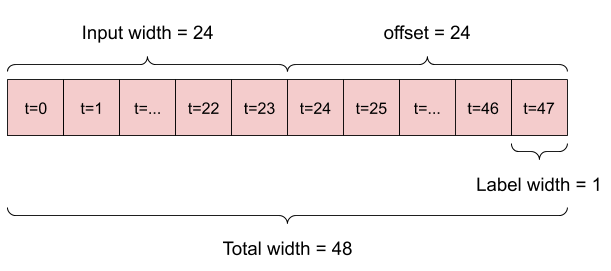

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

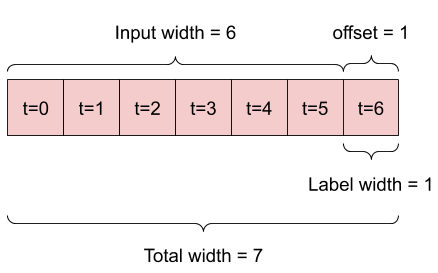

The rest of this section defines a WindowGenerator class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
2. Split windows of features into (features, labels) pairs.
3. Plot the content of the resulting windows.
4. Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.

## Indexes and offsets
Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.


In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)
  
  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result



Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [21]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [22]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

## Split
Given a list of consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.
The example w2 you define earlier will be split like this:

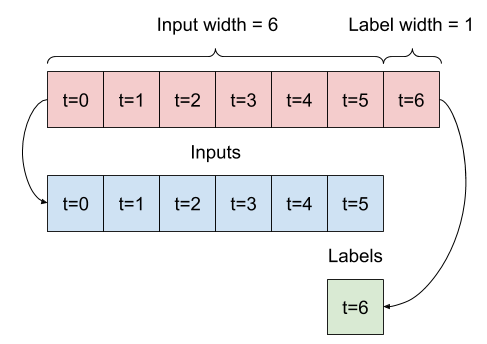

This diagram doesn't show the features axis of the data, but this split_window function also handles the label_columns so it can be used for both the single output and multi-output examples.

In [23]:
split_window = WindowGenerator.split_window 

In [24]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [25]:
example_inputs, example_labels = w2.example 

In [26]:
plot = WindowGenerator.plot 

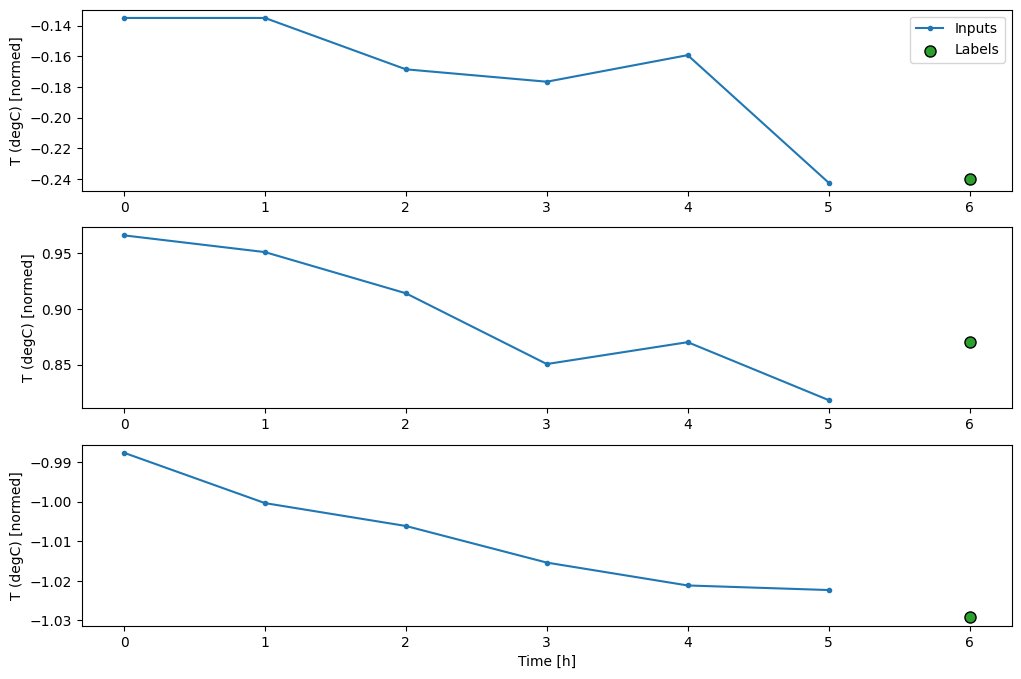

In [27]:
w2.plot()

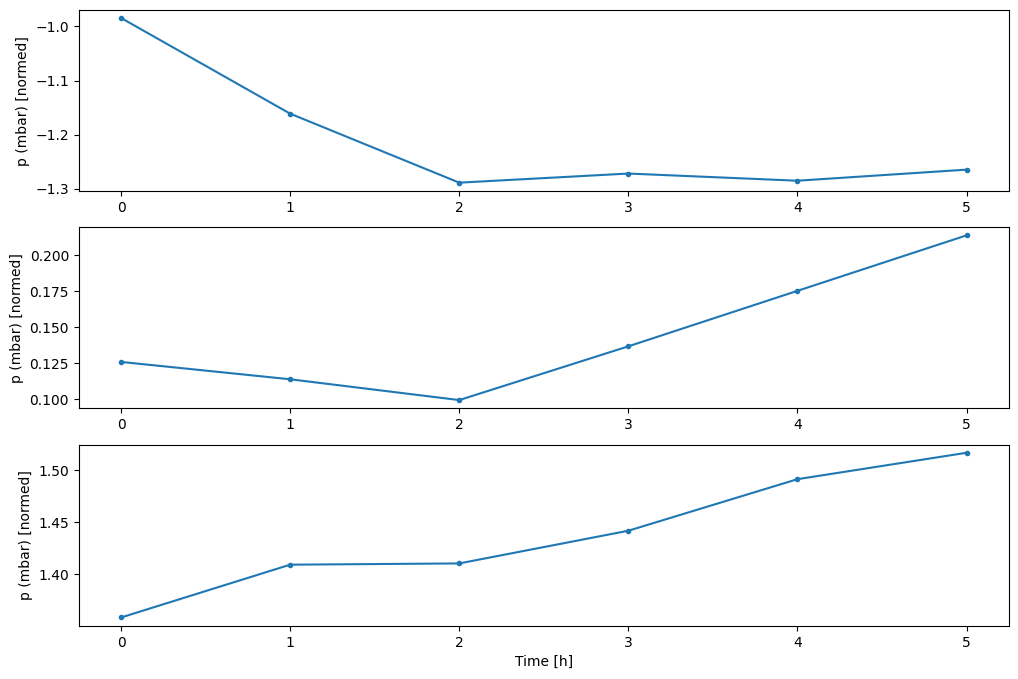

In [28]:
w2.plot(plot_col='p (mbar)')

## Create tf.data.Datasets
Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function:

In [29]:
make_dataset = WindowGenerator.make_dataset 

In [30]:
train = WindowGenerator.train 
val = WindowGenerator.val 
test = WindowGenerator.test 
example = WindowGenerator.example 

In [31]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [32]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


2024-07-11 15:09:06.205107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Single step models
The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the T (degC) value one hour into the future.

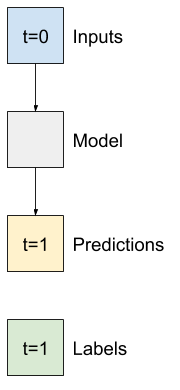

In [33]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


2024-07-11 15:09:09.581421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Baseline
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

Send the input to the output

![image.png](attachment:image.png)

In [35]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [36]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0132 - mean_absolute_error: 0.0795


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The WindowGenerator has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider WindowGenerator that generates windows 24 hours of consecutive inputs and labels at a time. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps:

In [37]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same baseline model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

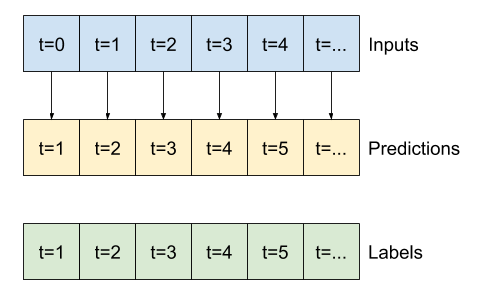

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


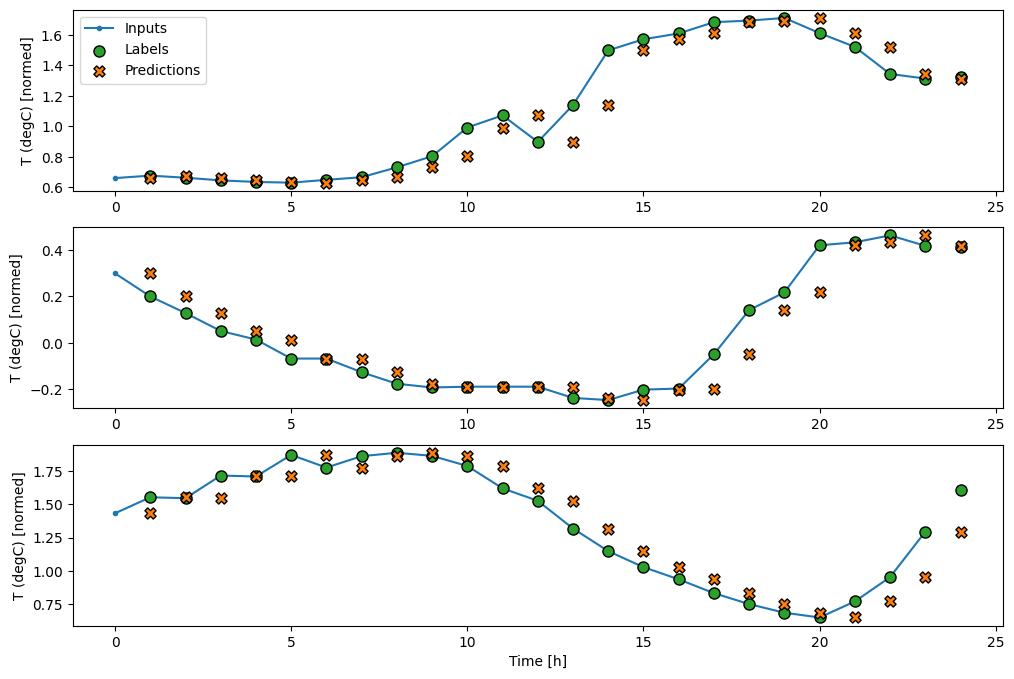

In [39]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

The blue Inputs line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
The green Labels dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
The orange Predictions crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the Labels.


## Linear model
The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

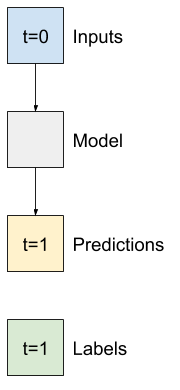

A tf.keras.layers.Dense layer with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units); it is applied independently to every item across the batch and time axes.

In [40]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [43]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 787us/step - loss: 0.8515 - mean_absolute_error: 0.6397 - val_loss: 0.0213 - val_mean_absolute_error: 0.1096
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 0.0186 - mean_absolute_error: 0.1026 - val_loss: 0.0116 - val_mean_absolute_error: 0.0807
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.0111 - mean_absolute_error: 0.0783 - val_loss: 0.0095 - val_mean_absolute_error: 0.0721
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 0.0097 - mean_absolute_error: 0.0724 - val_loss: 0.0090 - val_mean_absolute_error: 0.0701
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0089 - val_mean_absolute_error: 0.0694
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.0092 - mean_absolute_error: 0.0704 - val_loss: 0.0088 - val_mean_absolute_error: 0.0692
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.0092 - mea

Like the baseline model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The time axis acts like another batch axis. There are no interactions between the predictions at each time step.

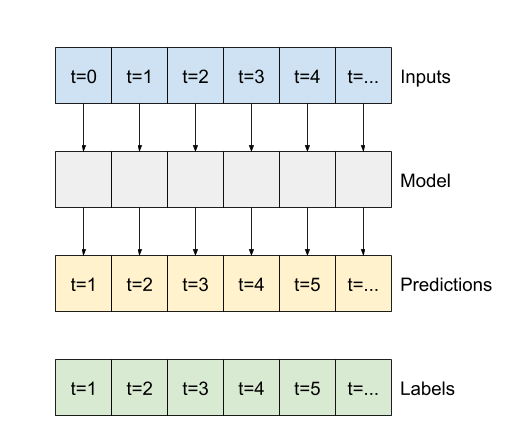


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


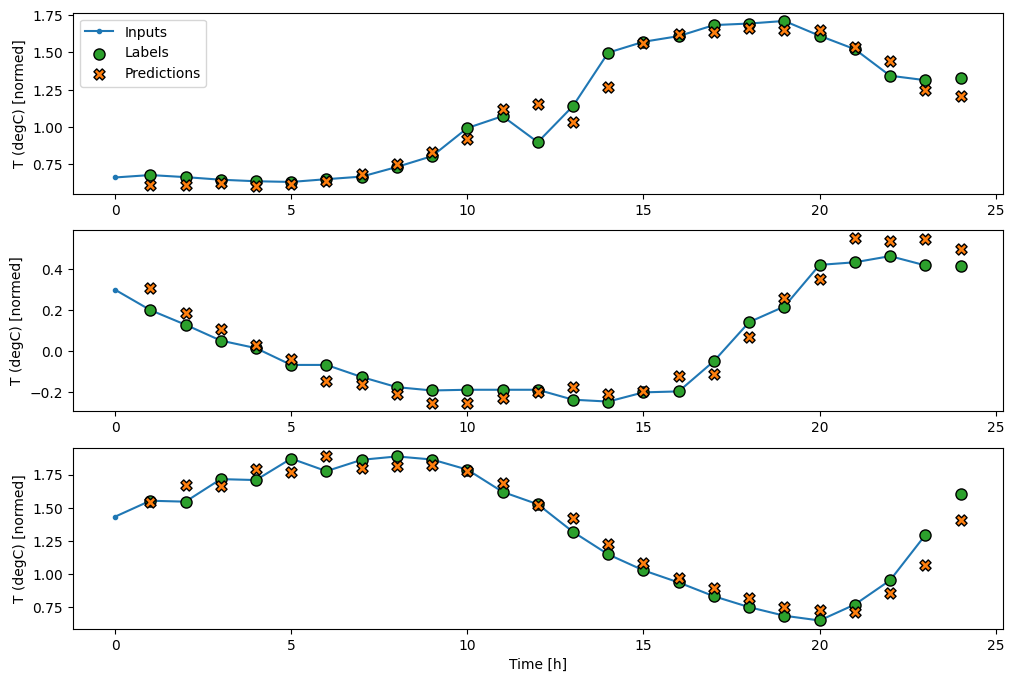

In [44]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)
wide_window.plot(linear)

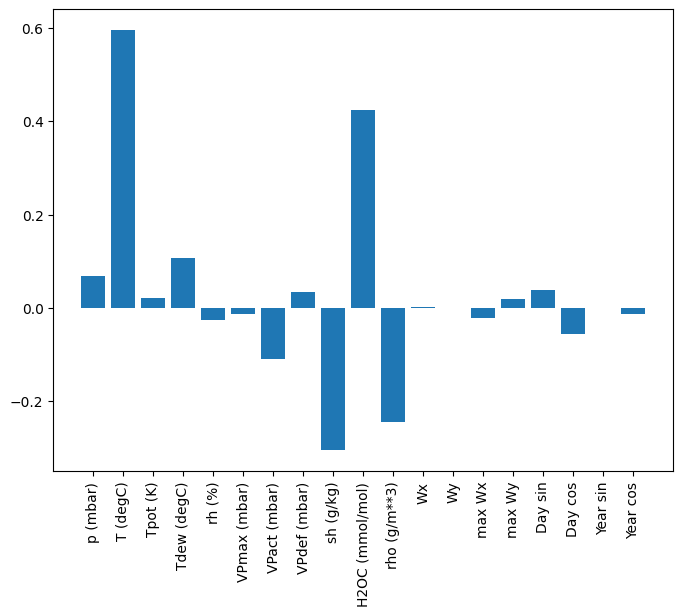

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

This model is linear as it has no activation fucntion to give it non-liear behaviour 

# Activation functions 
An activation function in the context of neural networks is a mathematical function applied to the output of a neuron (or node) in a network layer. Its primary purpose is to introduce non-linearity into the model, enabling the network to learn and represent more complex patterns in the data. Without activation functions, a neural network would simply be a series of linear transformations, and no matter how many layers it has, the entire network would still be equivalent to a single linear transformation.

### Types of Activation Functions

Here are some common activation functions and how they work:

1. **Sigmoid Function**:
   - Formula: \( \sigma(x) = \frac{1}{1 + e^{-x}} \)
   - Output Range: (0, 1)
   - Characteristics: S-shaped curve; used in binary classification problems. It squashes the input to a range between 0 and 1, making it interpretable as a probability.

2. **Tanh (Hyperbolic Tangent) Function**:
   - Formula: \( \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} \)
   - Output Range: (-1, 1)
   - Characteristics: Zero-centered, which can make optimization easier and faster. It squashes the input to a range between -1 and 1.

3. **ReLU (Rectified Linear Unit)**:
   - Formula: \( \text{ReLU}(x) = \max(0, x) \)
   - Output Range: [0, ∞)
   - Characteristics: Introduces sparsity (many activations are zero), which helps with efficient computation and mitigates the vanishing gradient problem. It is one of the most commonly used activation functions in deep learning.

4. **Leaky ReLU**:
   - Formula: \( \text{Leaky ReLU}(x) = \begin{cases} 
      x & \text{if } x > 0 \\
      \alpha x & \text{if } x \le 0
   \end{cases} \)
   - Output Range: (-∞, ∞)
   - Characteristics: Similar to ReLU but allows a small gradient when the unit is not active (i.e., \( x \le 0 \)), which helps to keep the information flowing through the network.

5. **Softmax Function**:
   - Formula: \( \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} \)
   - Output Range: (0, 1) for each element, with all outputs summing to 1
   - Characteristics: Used primarily in the output layer of a neural network for multi-class classification. It converts logits into probabilities.

### How Activation Functions Work

1. **Introducing Non-Linearity**:
   - Activation functions enable the neural network to learn non-linear mappings from inputs to outputs. Without non-linearity, a network with multiple layers would behave like a single linear layer.

2. **Enabling Complex Pattern Learning**:
   - Non-linear activation functions allow neural networks to model complex relationships and interactions in the data, which linear models cannot capture.

3. **Controlling Signal Flow**:
   - By setting certain neuron outputs to zero (as in ReLU), activation functions can control which neurons are activated, contributing to sparse representations that can be more efficient and can help in regularization.

### Example: ReLU Activation

Here’s a simple example showing how the ReLU activation function works:

- Input: \( x = [-2, -1, 0, 1, 2] \)
- ReLU Applied: \( \text{ReLU}(x) = [0, 0, 0, 1, 2] \)

As you can see, all negative values are set to zero, while positive values remain unchanged. This simple mechanism allows the network to decide which neurons should be active (non-zero output) based on the input data.



For this we will use the most commont activation function the ReLU


The vanishing gradient problem is an issue that can occur when training deep neural networks, where the gradients of the loss function with respect to the weights become very small. This can severely slow down or even stop the learning process for the layers in the network that are farther from the output layer. Here’s a detailed explanation:

### What Causes the Vanishing Gradient Problem?

1. **Backpropagation**:
   - During backpropagation, gradients are propagated backward from the output layer to the input layer.
   - Each layer’s gradient is computed using the chain rule, which involves multiplying gradients layer-by-layer.

2. **Activation Functions**:
   - Common activation functions like the sigmoid or tanh squash input values into a small range (0 to 1 for sigmoid, -1 to 1 for tanh).
   - When the input values to these functions are in the saturated regions (very high or very low), the derivatives of these functions are very small.

3. **Multiplication of Small Gradients**:
   - As gradients are backpropagated through many layers, the small gradients get multiplied together.
   - This results in an exponentially small gradient value for the earlier layers in the network, effectively making it nearly zero.

### Consequences of the Vanishing Gradient Problem

1. **Slow Learning**:
   - The weights in the earlier layers of the network learn very slowly because their gradients are tiny. This means that even if the network has a lot of capacity, it won’t be able to utilize it fully.

2. **Poor Performance**:
   - The network might not learn the important features in the data, especially those in the initial layers. This leads to suboptimal performance.

3. **Difficulty in Training Deep Networks**:
   - The vanishing gradient problem makes it challenging to train very deep networks. The deeper the network, the more severe the problem can become.

### Solutions to the Vanishing Gradient Problem

1. **Activation Functions**:
   - **ReLU (Rectified Linear Unit)**: ReLU and its variants (like Leaky ReLU) do not suffer as much from the vanishing gradient problem because they do not squash the gradients in the same way as sigmoid or tanh. ReLU activation function: \( \text{ReLU}(x) = \max(0, x) \).
   - **Leaky ReLU**: Allows a small, non-zero gradient when the unit is inactive: \( \text{Leaky ReLU}(x) = \begin{cases} 
      x & \text{if } x > 0 \\
      \alpha x & \text{if } x \le 0
   \end{cases} \), where \( \alpha \) is a small constant.

2. **Weight Initialization**:
   - **He Initialization**: For layers with ReLU activations, initializing weights using He initialization helps in maintaining the variance of the gradients. It sets the weights as: \( W \sim \mathcal{N}(0, \sqrt{2/n}) \), where \( n \) is the number of input units in the weight tensor.
   - **Xavier Initialization**: For sigmoid and tanh activations, Xavier initialization can be used: \( W \sim \mathcal{N}(0, \sqrt{1/n}) \) or \( W \sim \mathcal{U}(-\sqrt{6/n}, \sqrt{6/n}) \).

3. **Batch Normalization**:
   - Batch normalization normalizes the inputs of each layer to have a mean of zero and a variance of one. This helps in mitigating the vanishing gradient problem by ensuring that the inputs to activation functions are in a desirable range.

4. **Residual Networks (ResNets)**:
   - Residual networks introduce shortcut connections that skip one or more layers. This allows the gradient to flow directly through these connections, mitigating the vanishing gradient problem.

### Example: Vanishing Gradient Problem with Sigmoid

To illustrate the vanishing gradient problem, consider the sigmoid function:
\[ \sigma(x) = \frac{1}{1 + e^{-x}} \]

Its derivative is:
\[ \sigma'(x) = \sigma(x) (1 - \sigma(x)) \]

For large positive or negative \( x \), \( \sigma(x) \) approaches 0 or 1, making \( \sigma'(x) \) approach 0. If we multiply many such small derivatives, the gradient diminishes exponentially.

### Visualization



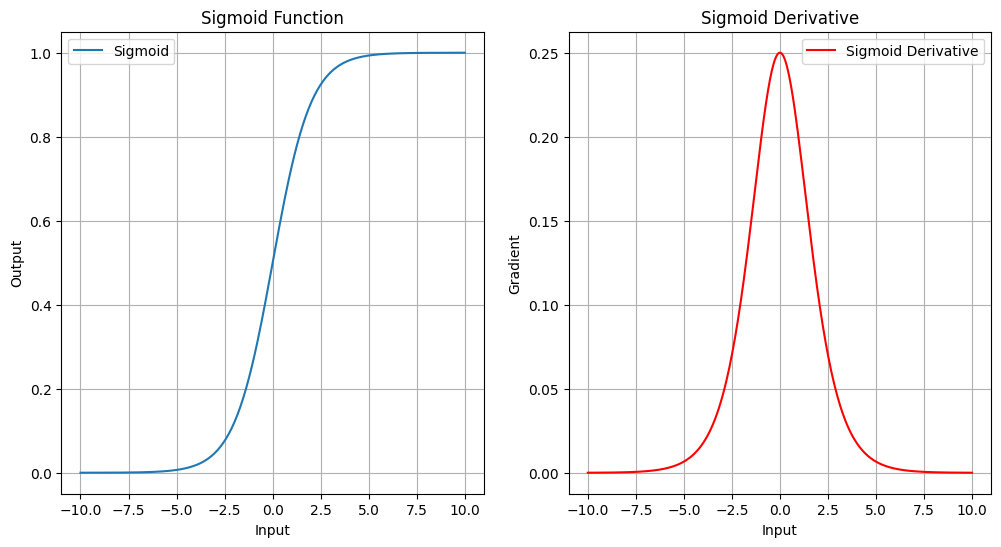

In [46]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 400)
sigmoid = 1 / (1 + np.exp(-x))
sigmoid_derivative = sigmoid * (1 - sigmoid)

plt.figure(figsize=(12, 6))

# Sigmoid function
plt.subplot(1, 2, 1)
plt.plot(x, sigmoid, label='Sigmoid')
plt.title('Sigmoid Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True)
plt.legend()

# Sigmoid derivative
plt.subplot(1, 2, 2)
plt.plot(x, sigmoid_derivative, label='Sigmoid Derivative', color='r')
plt.title('Sigmoid Derivative')
plt.xlabel('Input')
plt.ylabel('Gradient')
plt.grid(True)
plt.legend()

plt.show()


## Dense
Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the linear model, except it stacks several a few Dense layers between the input and the output:

In [47]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0334 - mean_absolute_error: 0.1069 - val_loss: 0.0101 - val_mean_absolute_error: 0.0726
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0652 - val_loss: 0.0073 - val_mean_absolute_error: 0.0627
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - loss: 0.0074 - mean_absolute_error: 0.0624 - val_loss: 0.0069 - val_mean_absolute_error: 0.0598
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 0.0072 - mean_absolute_error: 0.0611 - val_loss: 0.0067 - val_mean_absolute_error: 0.0585
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - loss: 0.0070 - mean_absolute_error: 0.0600 - val_loss: 0.0066 - val_mean_absolute_error: 0.0575
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0591 - val_loss: 0.0065 - val_mean_absolute_error: 0.0569
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - loss: 0.0068 - mean_abso

## Multi-step dense
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

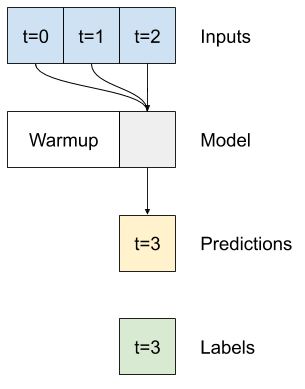

The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of three-hour inputs and one-hour labels:

Note that the Window's shift parameter is relative to the end of the two windows.

In [48]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

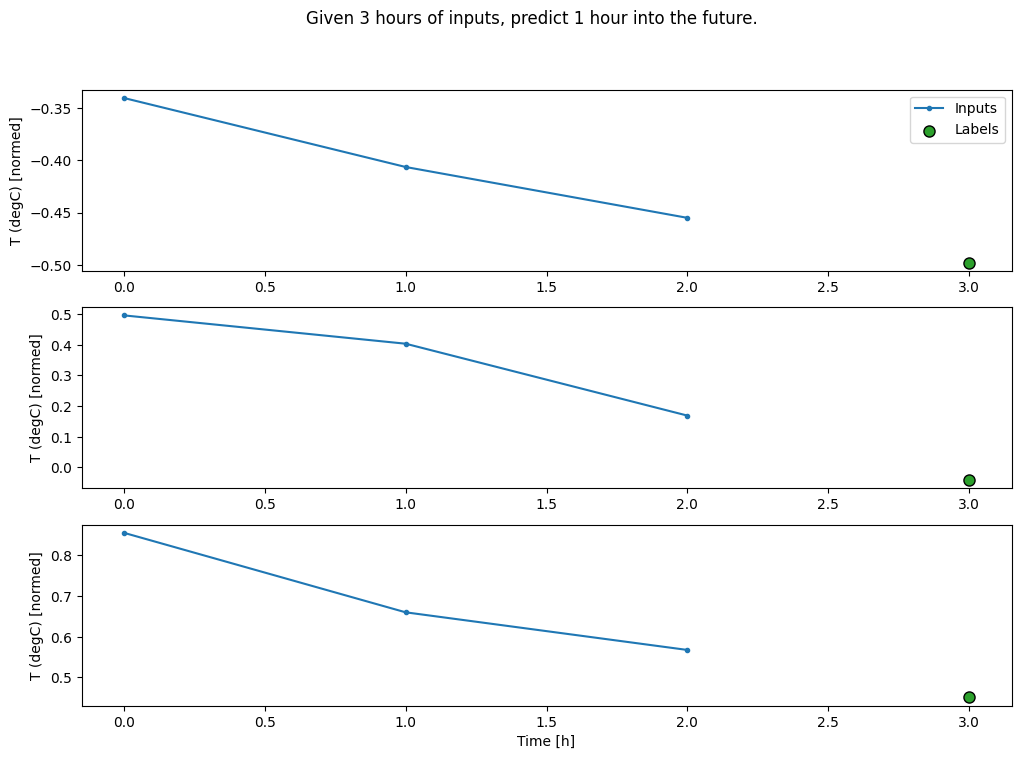

In [49]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a dense model on a multiple-input-step window by adding a tf.keras.layers.Flatten as the first layer of the model:



In [50]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [51]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.0066 - mean_absolute_error: 0.0580


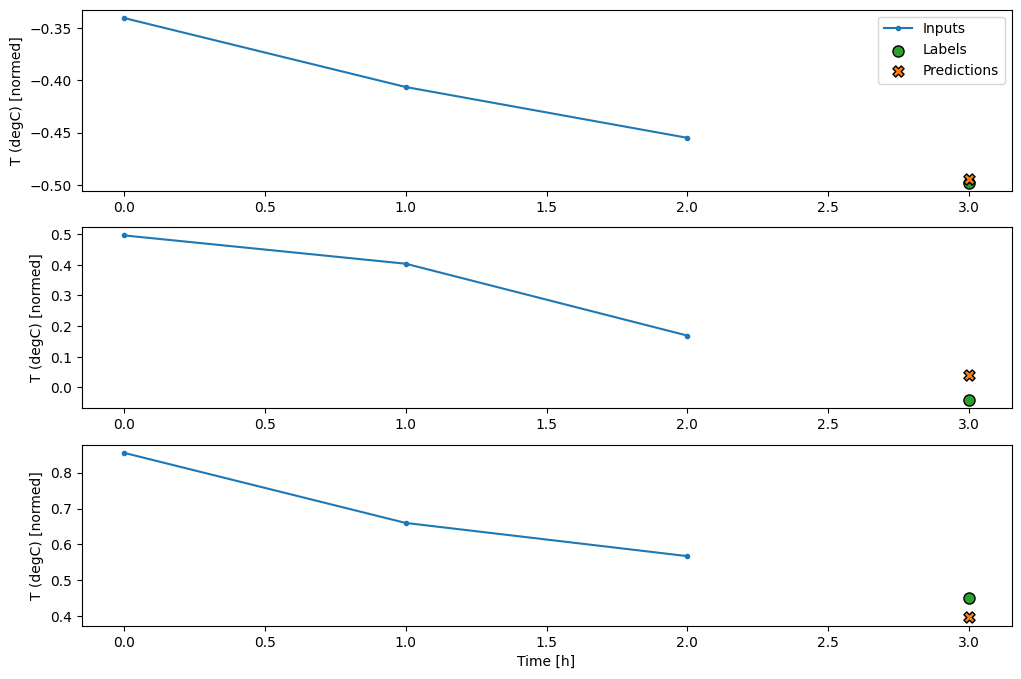

In [53]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [54]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

## Convolution neural network
A convolution layer (tf.keras.layers.Conv1D) also takes multiple time steps as input to each prediction.

Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:

- The tf.keras.layers.Flatten and the first tf.keras.layers.Dense are    replaced by a tf.keras.layers.Conv1D.
- The tf.keras.layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.

In [55]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [56]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [57]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0068 - mean_absolute_error: 0.0585


The difference between this conv_model and the multi_step_dense model is that the conv_model can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

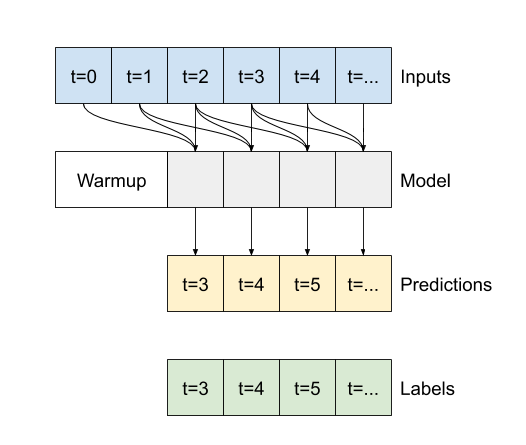


In [58]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match:




In [59]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

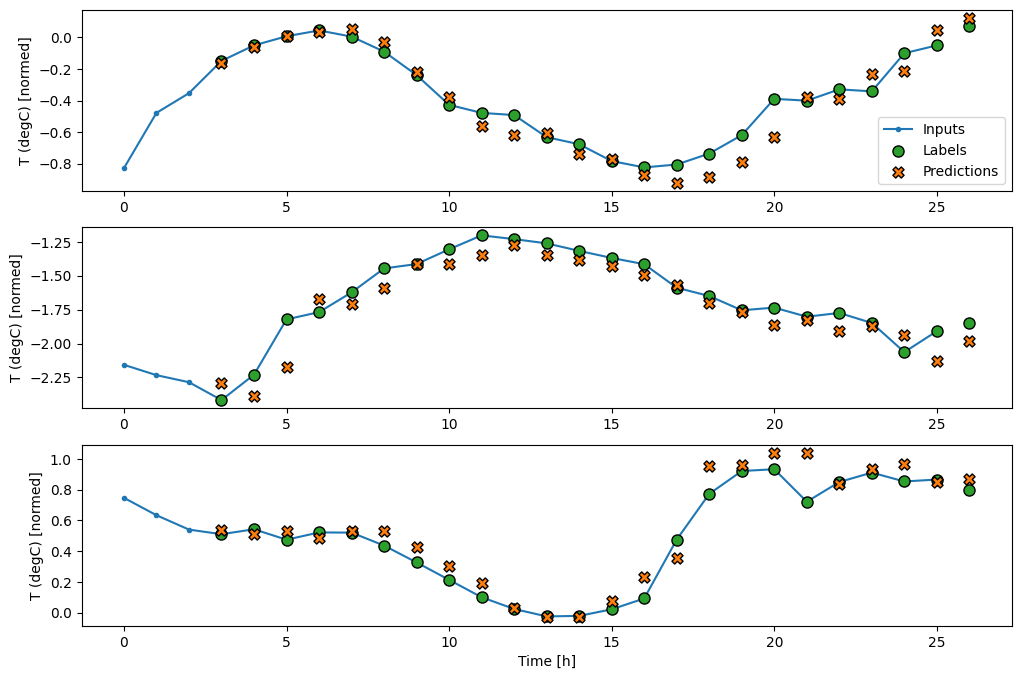

In [60]:
wide_conv_window.plot(conv_model)